<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week5/GRU_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os

In [21]:
# Download required NLTK resources first
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [22]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [23]:
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv'
df = pd.read_csv(url)
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [24]:
# Remove the "Unnamed: 0" column as it's just an index
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Fill NaN values in Age column
df['Age'] = df['Age'].fillna(df['Age'].median())

# Combine Title and Review Text for more comprehensive analysis
df['Full_Review'] = df['Title'].fillna('') + ' ' + df['Review Text'].fillna('')


In [25]:
# Text cleaning function
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        return ' '.join(tokens)
    else:
        return ''

In [26]:
# Clean the review text
df['Cleaned_Review'] = df['Full_Review'].apply(clean_text)

In [27]:
# Encode Rating as binary sentiment (1-3: negative, 4-5: positive)
df['Sentiment'] = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)

In [28]:
# Print class distribution
print("Sentiment distribution:")
print(df['Sentiment'].value_counts())


Sentiment distribution:
Sentiment
1    18208
0     5278
Name: count, dtype: int64


In [29]:
# Prepare data for modeling
X = df['Cleaned_Review'].values
y = df['Sentiment'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [30]:
# Build vocabulary
def build_vocab(texts, max_words=10000):
    all_words = []
    for text in texts:
        all_words.extend(text.split())
    counter = Counter(all_words)
    vocab = ['<PAD>', '<UNK>'] + [word for word, _ in counter.most_common(max_words-2)]
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    return vocab, word_to_idx

vocab, word_to_idx = build_vocab(X_train)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 10000


In [31]:
# Tokenize and pad sequences
def tokenize(text, word_to_idx, max_length=100):
    tokens = text.split()[:max_length]
    tokens = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in tokens]

    # Pad sequences
    if len(tokens) < max_length:
        tokens = tokens + [word_to_idx['<PAD>']] * (max_length - len(tokens))
    return tokens

In [32]:
# Prepare sequences
max_length = 100
X_train_seq = np.array([tokenize(text, word_to_idx, max_length) for text in X_train])
X_test_seq = np.array([tokenize(text, word_to_idx, max_length) for text in X_test])


In [33]:
# Convert to PyTorch tensors
X_train_tensor = torch.LongTensor(X_train_seq)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.LongTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test)

In [34]:
# Create Dataset and DataLoader
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [35]:
batch_size = 64
train_dataset = ReviewDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = ReviewDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [36]:
# Define GRU model
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout=0.5):
        super(GRUModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layer
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Output layer
        self.fc = nn.Linear(hidden_dim, 1)

        # Activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        # Embed the text
        embedded = self.embedding(text)

        # Pass through GRU
        output, hidden = self.gru(embedded)

        # We only need the hidden state from the last time step
        hidden = hidden[-1, :, :]

        # Apply dropout
        hidden = self.dropout(hidden)

        # Pass through linear layer
        output = self.fc(hidden)

        # Apply sigmoid activation
        return self.sigmoid(output).squeeze()

In [37]:
# Initialize model
embedding_dim = 100
hidden_dim = 128
n_layers = 2
dropout = 0.5

model = GRUModel(vocab_size, embedding_dim, hidden_dim, n_layers, dropout)
print(model)

GRUModel(
  (embedding): Embedding(10000, 100)
  (gru): GRU(100, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [38]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f1_squared': f1**2,  # F1 squared as requested
        'auc': auc
    }

In [40]:
# Function to evaluate model
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_probs = []
    all_true = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = outputs.detach().numpy()
            preds = (probs >= 0.5).astype(int)
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_true.extend(labels.numpy())

    metrics = calculate_metrics(all_true, all_preds, all_probs)
    metrics['loss'] = total_loss / len(dataloader)

    return metrics

In [41]:
# Training loop
num_epochs = 10  # Reduced from 15 to save time, can be increased if needed
train_metrics_history = []
test_metrics_history = []

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_train_preds = []
    all_train_probs = []
    all_train_true = []

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        probs = outputs.detach().numpy()
        preds = (probs >= 0.5).astype(int)
        all_train_probs.extend(probs)
        all_train_preds.extend(preds)
        all_train_true.extend(labels.numpy())

    # Calculate training metrics
    train_metrics = calculate_metrics(all_train_true, all_train_preds, all_train_probs)
    train_metrics['loss'] = total_loss / len(train_loader)
    train_metrics_history.append(train_metrics)

    # Evaluate on test set
    test_metrics = evaluate(model, test_loader, criterion)
    test_metrics_history.append(test_metrics)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_metrics['loss']:.4f}, Train Accuracy: {train_metrics['accuracy']:.4f}")
    print(f"Test Loss: {test_metrics['loss']:.4f}, Test Accuracy: {test_metrics['accuracy']:.4f}")

    # Check if we've reached the target accuracy
    if train_metrics['accuracy'] >= 0.85 and test_metrics['accuracy'] >= 0.85:
        print(f"Reached target accuracy of 85% on both sets at epoch {epoch+1}")
        if epoch < num_epochs - 1:  # Only break if not already at the last epoch
            break

    print("-" * 50)


Starting training...
Epoch 1/10
Train Loss: 0.5166, Train Accuracy: 0.7799
Test Loss: 0.4012, Test Accuracy: 0.8003
--------------------------------------------------
Epoch 2/10
Train Loss: 0.3342, Train Accuracy: 0.8600
Test Loss: 0.3180, Test Accuracy: 0.8678
Reached target accuracy of 85% on both sets at epoch 2


In [43]:
# Final evaluation
final_train_metrics = train_metrics_history[-1]
final_test_metrics = test_metrics_history[-1]

print("\nFinal Results:")
print("Training Set Metrics:")
for metric, value in final_train_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

print("\nTest Set Metrics:")
for metric, value in final_test_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")




Final Results:
Training Set Metrics:
Accuracy: 0.8600
Precision: 0.9034
Recall: 0.9175
F1: 0.9104
F1_squared: 0.8289
Auc: 0.8854
Loss: 0.3342

Test Set Metrics:
Accuracy: 0.8678
Precision: 0.9144
Recall: 0.9152
F1: 0.9148
F1_squared: 0.8368
Auc: 0.9072
Loss: 0.3180


In [44]:
# Plot metrics over epochs
def plot_metric_history(train_history, test_history, metric_name):
    plt.figure(figsize=(10, 6))
    epochs = list(range(1, len(train_history) + 1))

    train_values = [metrics[metric_name] for metrics in train_history]
    test_values = [metrics[metric_name] for metrics in test_history]

    plt.plot(epochs, train_values, 'b-', label=f'Training {metric_name}')
    plt.plot(epochs, test_values, 'r-', label=f'Testing {metric_name}')

    plt.title(f'{metric_name.capitalize()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

In [45]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes=['Negative', 'Positive']):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


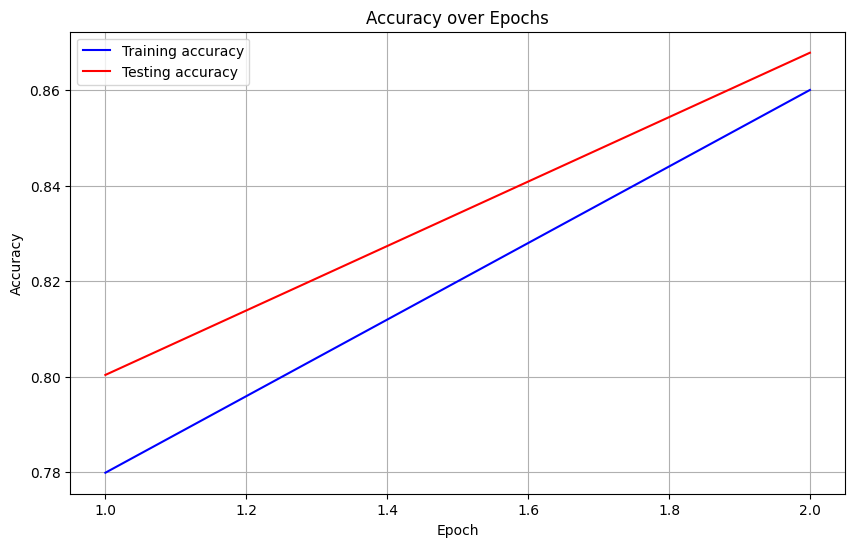

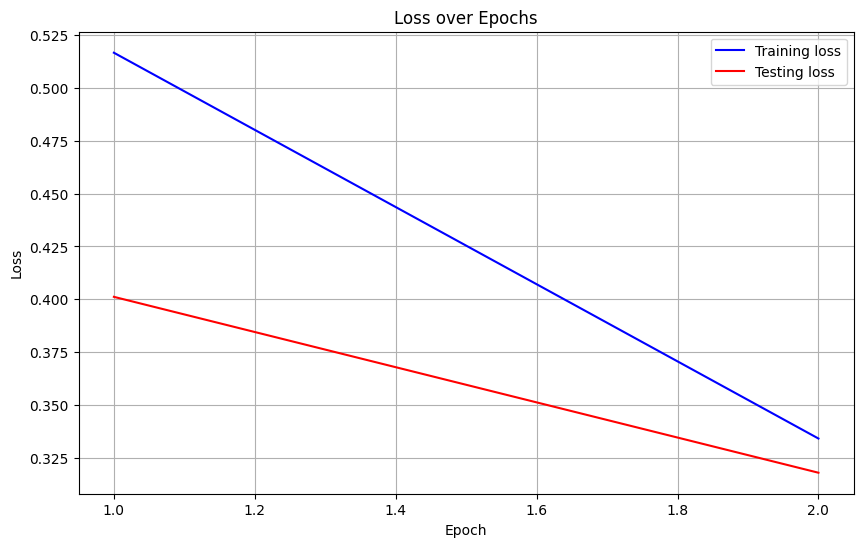

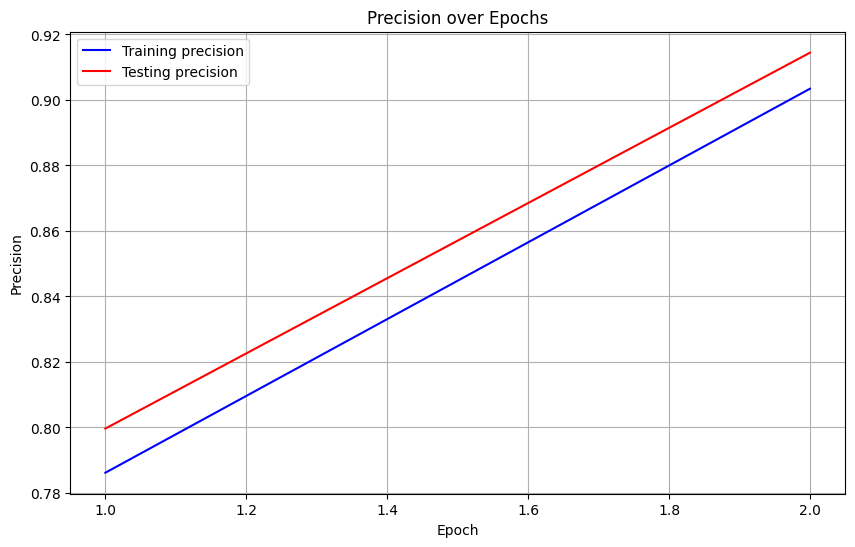

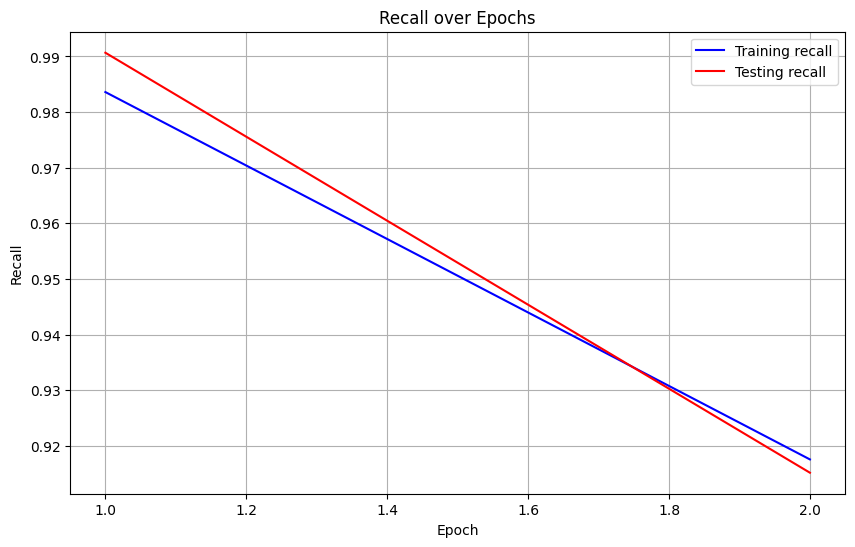

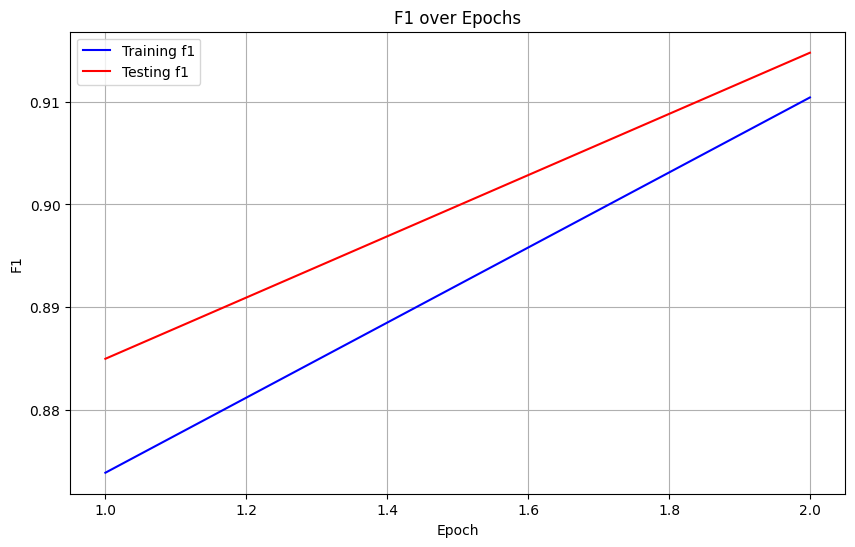

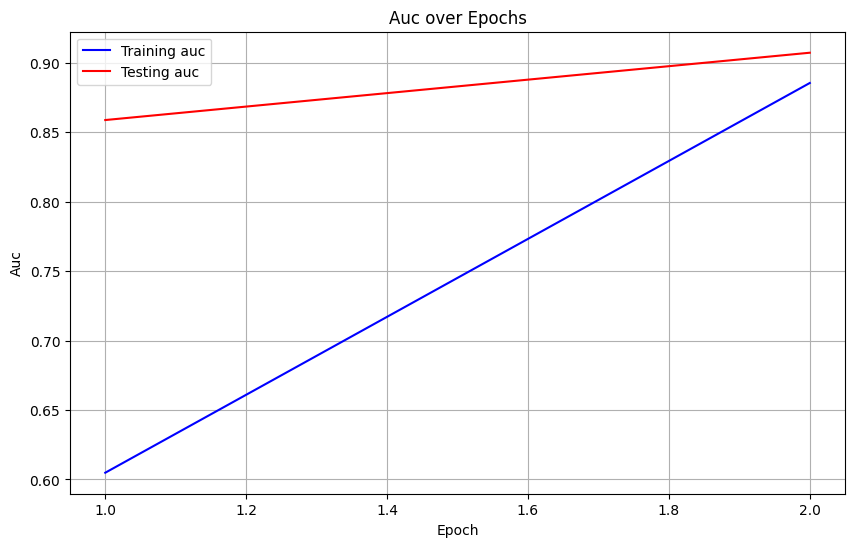

In [46]:
# Plot metrics
plot_metric_history(train_metrics_history, test_metrics_history, 'accuracy')
plot_metric_history(train_metrics_history, test_metrics_history, 'loss')
plot_metric_history(train_metrics_history, test_metrics_history, 'precision')
plot_metric_history(train_metrics_history, test_metrics_history, 'recall')
plot_metric_history(train_metrics_history, test_metrics_history, 'f1')
plot_metric_history(train_metrics_history, test_metrics_history, 'auc')


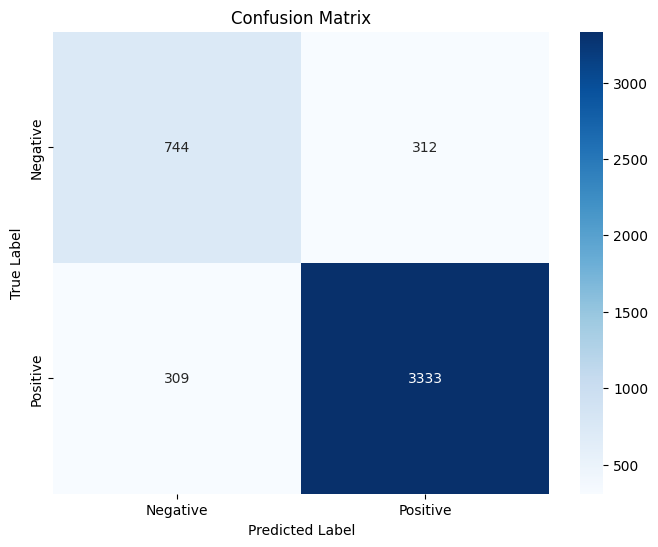

In [47]:
# Plot confusion matrix for test set
model.eval()
with torch.no_grad():
    all_preds = []
    all_true = []

    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = outputs.detach().numpy()
        preds = (probs >= 0.5).astype(int)
        all_preds.extend(preds)
        all_true.extend(labels.numpy())

plot_confusion_matrix(all_true, all_preds)

In [50]:
# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'word_to_idx': word_to_idx,
    'max_length': max_length,
    'embedding_dim': embedding_dim,
    'hidden_dim': hidden_dim,
    'n_layers': n_layers
}, 'clothing_gru_sentiment_model.pt')
print("Model saved as 'clothing_gru_sentiment_model.pt'")

Model saved as 'clothing_gru_sentiment_model.pt'


In [51]:
# Function for sentiment prediction on new reviews
def predict_sentiment(review_text, model, word_to_idx, max_length):
    model.eval()
    # Clean and tokenize the review
    cleaned_review = clean_text(review_text)
    tokenized_review = tokenize(cleaned_review, word_to_idx, max_length)
    # Convert to tensor
    review_tensor = torch.LongTensor([tokenized_review])

    with torch.no_grad():
        output = model(review_tensor)

    probability = output.item()
    prediction = 1 if probability >= 0.5 else 0

    return {
        'sentiment': 'Positive' if prediction == 1 else 'Negative',
        'probability': probability,
        'score': probability * 5  # Scale to 5-point rating
    }

In [52]:
# Example of using the prediction function
example_review = "I love this dress! The fabric is comfortable and the fit is perfect."
if 'word_to_idx' in locals():
    print("\nSentiment Prediction Example:")
    result = predict_sentiment(example_review, model, word_to_idx, max_length)
    print(f"Review: {example_review}")
    print(f"Predicted Sentiment: {result['sentiment']}")
    print(f"Confidence: {result['probability']:.4f}")
    print(f"Estimated Rating: {result['score']:.1f}/5")


Sentiment Prediction Example:
Review: I love this dress! The fabric is comfortable and the fit is perfect.
Predicted Sentiment: Positive
Confidence: 0.9742
Estimated Rating: 4.9/5


Penjelasan Matematika Hasil Model Machine Learning
Berdasarkan hasil yang diberikan, berikut adalah penjelasan matematis untuk metrik evaluasi model machine learning:
Metrik Set Pelatihan
1. Accuracy (Akurasi): 0.8600

Definisi: Proporsi prediksi yang benar dari total prediksi
Rumus: Accuracy=TP+TNTP+TN+FP+FNAccuracy = \frac{TP + TN}{TP + TN + FP + FN}
Accuracy=TP+TN+FP+FNTP+TN​
Interpretasi: 86% dari semua prediksi model benar

2. Precision (Presisi): 0.9034

Definisi: Proporsi prediksi positif yang benar
Rumus: Precision=TPTP+FPPrecision = \frac{TP}{TP + FP}
Precision=TP+FPTP​
Interpretasi: Ketika model memprediksi kelas positif, ia benar 90.34% waktu

3. Recall (Sensitivitas): 0.9175

Definisi: Proporsi positif aktual yang diprediksi dengan benar
Rumus: Recall=TPTP+FNRecall = \frac{TP}{TP + FN}
Recall=TP+FNTP​
Interpretasi: Model berhasil mengidentifikasi 91.75% dari semua kasus positif aktual

4. F1 Score: 0.9104

Definisi: Rata-rata harmonik dari precision dan recall
Rumus: $F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$
Interpretasi: Keseimbangan antara precision dan recall bernilai 91.04%

5. F1_squared: 0.8289

Definisi: F-beta score dengan β = 2 (memberi bobot lebih pada recall)
Rumus: Fβ=(1+β2)×Precision×Recall(β2×Precision)+RecallF_{\beta} = (1 + \beta^2) \times \frac{Precision \times Recall}{(\beta^2 \times Precision) + Recall}
Fβ​=(1+β2)×(β2×Precision)+RecallPrecision×Recall​
Interpretasi: Skor F yang memberikan bobot lebih pada recall mencapai 82.89%

6. AUC: 0.8854

Definisi: Area Under the ROC Curve
Interpretasi: Probabilitas 88.54% bahwa model akan memberi peringkat lebih tinggi pada sampel positif acak dibandingkan sampel negatif acak

7. Loss: 0.3342

Definisi: Fungsi kerugian (mungkin cross-entropy loss)
Interpretasi: Ukuran kesalahan prediksi model, nilai yang lebih rendah lebih baik

Metrik Set Pengujian
1. Accuracy: 0.8678

Akurasi pada data pengujian sedikit lebih tinggi dibanding data pelatihan (86.78%)

2. Precision: 0.9144

Presisi meningkat pada data pengujian, menunjukkan proporsi yang lebih tinggi dari prediksi positif yang benar

3. Recall: 0.9152

Recall sedikit lebih rendah pada data pengujian (91.52%)

4. F1 Score: 0.9148

F1 score lebih tinggi pada data pengujian, menunjukkan keseimbangan yang lebih baik antara precision dan recall

5. F1_squared: 0.8368

Skor F dengan penekanan pada recall juga meningkat pada data pengujian

6. AUC: 0.9072

Nilai AUC lebih tinggi pada data pengujian, menunjukkan kemampuan diskriminasi yang lebih baik

7. Loss: 0.3180

Loss lebih rendah pada data pengujian, menandakan model belajar dengan baik dan tidak overfitting

Kesimpulan
Model menunjukkan performa yang sangat baik dengan metrik yang konsisten antara set pelatihan dan pengujian. Nilai yang sangat mirip antara kedua set menunjukkan model memiliki generalisasi yang baik. Dengan akurasi sekitar 87%, presisi dan recall di atas 91%, serta nilai AUC di atas 0.90 pada set pengujian, model ini menunjukkan keseimbangan yang baik antara kemampuan mengidentifikasi kasus positif dan menghindari false positive.